In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mylibrary.nnlib as tnn
import mylibrary.splinelib as tsp

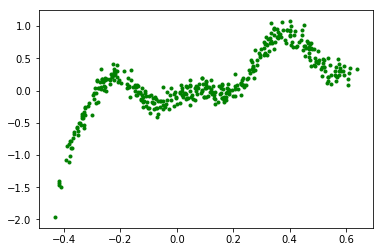

In [2]:
x = np.linspace(0,1,400)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
y = (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise
x = x - 0.4 #x.mean() # good practice to zero-center x in linear mapping
sortindx = np.argsort(x)
x = x[sortindx]
y = y[sortindx]
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)
xy = np.c_[xx,yy]
plt.scatter(x, y, marker='.', color='g')

## Reverse Function 

In [3]:
def reverse0(self:tsp.Spline1D, y):
    x = np.zeros_like(self.input)
    for i in range(self.n_points-1):
        xpossible = self.diffX[i]/self.diffY[i] *(y - self.Y[i]) + self.X[i]
        x += xpossible*self.rangeX[i]
    return x

In [4]:
def _calculate_rangeY_(self:tsp.Spline1D, y):
    rangeY = np.zeros((self.n_points-1, y.shape[0]))
    def _inrange2_(X, break0, break1): #if x is after
        xmsk1 = X >= break0
        xmsk2 = X < break1
        xmsk12 = np.bitwise_and(xmsk1, xmsk2)
        xmsk3 = X < break0
        xmsk4 = X >= break1
        xmsk34 = np.bitwise_and(xmsk3, xmsk4)
        xs = np.bitwise_or(xmsk12, xmsk34)
        return xs

    for i in range(self.n_points-1):
        if self.n_points-2 == 0:
            rangeY[i] = _inrange2_(y, -np.inf, np.inf)
        elif i==0:
            sign = -1 if self.Y[0]<self.Y[1] else 1
            rangeY[i] = _inrange2_(y, sign*np.inf, self.Y[1])
        elif i== self.n_points-2:
            sign = 1 if self.Y[i]<self.Y[i+1] else -1
            rangeY[i] = _inrange2_(y, self.Y[i], sign*np.inf)
        else:
            rangeY[i] = _inrange2_(y, self.Y[i], self.Y[i+1])
    return rangeY

def reverse1(self:tsp.Spline1D, y, rangeY=None):
    if rangeY is None:
        rangeY = _calculate_rangeY_(self, y)
        
    x = np.zeros_like(self.rangeX)
    for i in range(self.n_points-1):
        xpossible = self.diffX[i]/self.diffY[i] *(y - self.Y[i]) + self.X[i]
        x[i] = xpossible*rangeY[i]
    return x

In [5]:
# def reverse_spline_vector(self:tsp.SplineVectorLayer, y):
#     recons = np.empty_like(self.input)
#     for i in range(self.dimension):
#         yi = y[:, i]
#         reconsi = reverse0(self.spline_list[i], yi)
#         recons[:, i] = reconsi
#     return recons

# def _backward_target_(self:tsp.Spline1D, del_recons):
#     dtarg = np.zeros_like(self.output)
#     for i in range(self.n_points-1):
#         dtarg = dtarg + self.diffX[i]/self.diffY[i] *self.rangeX[i]

#     dtarg = dtarg*del_recons
#     return dtarg

# def backward_reverse_spline_vector(self:tsp.SplineVectorLayer, del_recons):
#     del_targ = np.empty_like(self.output)
#     for i in range(self.dimension):
#         del_reconsi = del_recons[:,i]
#         del_targi = _backward_target_(self.spline_list[i], del_reconsi)
#         del_targ[:, i] = del_targi
#     return del_targ

## Network

In [6]:
max_points = 7
i = np.linspace(-1,1,num=len(x))
i2x = tsp.Spline1D(max_points, x=i, y=x)
i2y = tsp.Spline1D(max_points, x=i, y=y)

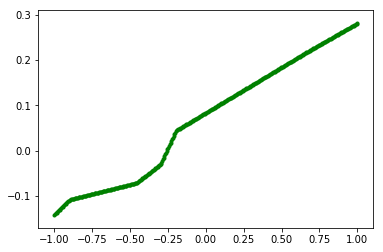

In [7]:
x_ = i2x.forward(i)
plt.scatter(i, x_, marker='.', color='g')

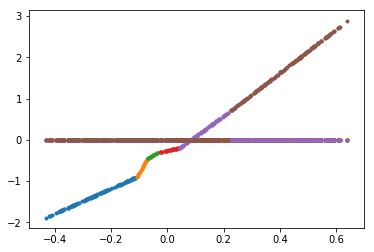

In [8]:
i_ = reverse1(i2x, x)
for ii in i_:
    plt.scatter(x, ii, marker='.')

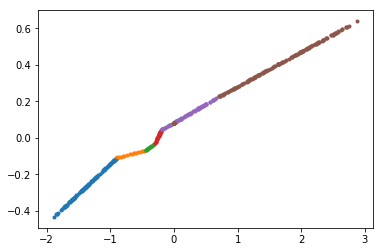

In [9]:
for ii in i_:
    x_ = i2x.forward(ii)
    plt.scatter(ii, x_, marker='.')

In [10]:
## similar is applicable for i2y as well

In [11]:
## Now building the model
# 1. x-->i    ; i-->y  ;
#    dx<--di  ; di<--dy;
# 2. y-->i    ; i-->x  ;
#    dy<--di  ; di<--dx;

In [12]:
## the first step
i_ = reverse1(i2x, x)
y_list = []
for ii in i_:
    y_ = i2y.forward(ii)
    y_list.append(y_)

In [13]:
indx_of_min_error = np.empty_like(y, dtype=np.int64)
min_error = np.ones_like(y)*99999
for indx, y_ in enumerate(y_list):
    dy_ = y_ - y
    candidate = np.nonzero(dy_ < min_error)
    min_error[candidate] = dy_[candidate]
    indx_of_min_error[candidate] = indx

In [14]:
indx_of_min_error

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
newi_ = np.zeros_like(i)
for indx, ii in enumerate(i_):
    mask = indx_of_min_error == indx
    newi_[mask] = ii[mask]
newi_.shape

(400,)

In [16]:
## Now forwarding these newi_ for getting the value of y
y_ = i2y.forward(newi_)
dy_ = y_ - y
di_ = i2y.backward(dy_)
print('error = ', (dy_**2).mean())

error =  1.0634904279723232


In [17]:
i2y.update()
y_ = i2y.forward(newi_)
dy_ = y_ - y
# di_ = i2y.backward(dy_)
print('updated error = ', (dy_**2).mean())

updated error =  0.9599204842619519


In [18]:
## the second step
y_ = i2y.forward(i)
i_ = reverse1(i2y, y)
x_list = []
for ii in i_:
    x_ = i2x.forward(ii)
    x_list.append(x_)

In [19]:
indx_of_min_error = np.empty_like(x, dtype=np.int64)
min_error = np.ones_like(x)*99999
for indx, x_ in enumerate(x_list):
    dx_ = x_ - x
    candidate = np.nonzero(dx_ < min_error)
    min_error[candidate] = dx_[candidate]
    indx_of_min_error[candidate] = indx
indx_of_min_error

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [20]:
newi_ = np.zeros_like(i)
for indx, ii in enumerate(i_):
    mask = indx_of_min_error == indx
    newi_[mask] = ii[mask]
newi_.shape

(400,)

In [21]:
## Now forwarding these newi_ for getting the value of y
x_ = i2x.forward(newi_)
dx_ = x_ - x
di_ = i2x.backward(dx_)
print('error = ', (dx_**2).mean())

error =  0.1724091728224608


In [22]:
i2x.update()
x_ = i2x.forward(newi_)
dx_ = x_ - x
# di_ = i2x.backward(dx_)
print('updated error = ', (dx_**2).mean())

updated error =  1135.8357792051863


## Doing the optimization continuously

In [23]:
real_max = 20
max_points = 5
i = np.linspace(-1,1,num=len(x))
i2x = tsp.Spline1D(max_points, x=i, y=x)
i2y = tsp.Spline1D(max_points, x=i, y=y)

_______________________
Steps 0
Error 0.09302474447898536 1.1435038235347794 1.2365285680137648


_______________________
Steps 10
Error 0.06762607754164775 0.6274511781390306 0.6950772556806784


_______________________
Steps 20
Error 0.061424553009062265 0.4542793282218303 0.5157038812308926


_______________________
Steps 30
Error 0.056338410628516904 0.34094630621736927 0.3972847168458862


_______________________
Steps 40
Error 0.052236540041786315 0.2651252381294993 0.3173617781712856


_______________________
Steps 50
Error 0.04891193944670607 0.21250715959194708 0.2614190990386531


_______________________
Steps 60
Error 0.04632633388965852 0.17433292808245546 0.22065926197211397


_______________________
Steps 70
Error 0.044477986495027724 0.1458075862118519 0.19028557270687962


_______________________
Steps 80
Error 0.043244653223914374 0.1236643981366534 0.16690905136056777


_______________________
Steps 90
Error 0.04281004356209407 0.10712880414999831 0.14993884771209237




_______________________
Steps 820
Error 0.0836765706079625 0.1992212907867673 0.28289786139472983


_______________________
Steps 830
Error 0.08366507863719315 0.19907684548990318 0.2827419241270963


_______________________
Steps 840
Error 0.08366223313427984 0.1989714285799144 0.28263366171419424


_______________________
Steps 850
Error 0.0836719655419477 0.19889453446689306 0.28256650000884076


_______________________
Steps 860
Error 0.08367166662880714 0.19883833578912352 0.2825100024179307


_______________________
Steps 870
Error 0.08360996998270545 0.19879282396767295 0.2824027939503784


_______________________
Steps 880
Error 0.08356472913184017 0.19875684266566368 0.28232157179750383


_______________________
Steps 890
Error 0.08352461594973999 0.1987284038024366 0.2822530197521766


_______________________
Steps 900
Error 0.08349685289211833 0.1987051558497379 0.28220200874185625


_______________________
Steps 910
Error 0.0843936159727881 0.19926865120535303 0.283662267



_______________________
Steps 1630
Error 0.083582496060329 0.19907465521190962 0.2826571512722386


_______________________
Steps 1640
Error 0.08355328815682622 0.19907491682398717 0.2826282049808134


_______________________
Steps 1650
Error 0.08353585368858234 0.19907041676020618 0.2826062704487885


_______________________
Steps 1660
Error 0.08352425263344916 0.19907136070285034 0.2825956133362995


_______________________
Steps 1670
Error 0.08351530939836473 0.1990639361086221 0.2825792455069868


_______________________
Steps 1680
Error 0.08350816965258201 0.19906322884552657 0.2825713984981086


_______________________
Steps 1690
Error 0.08350147151183539 0.19906390180494718 0.28256537331678255


_______________________
Steps 1700
Error 0.08349548451710788 0.19906446718611295 0.28255995170322085


_______________________
Steps 1710
Error 0.0846694197545223 0.19907301267409566 0.28374243242861796


_______________________
Steps 1720
Error 0.08414256745896194 0.19908165981999285 

TclError: invalid command name "pyimage17"

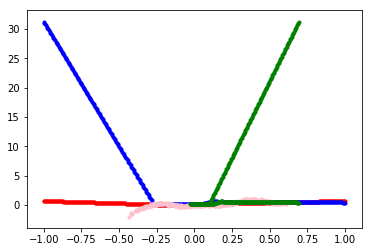

In [24]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

learning_rate = 0.03
for step in range(10000):
    ## the first step
    x_ = i2x.forward(i)
    i_ = reverse1(i2x, x)
    y_list = []
    for ii in i_:
        y_ = i2y.forward(ii)
        y_list.append(y_)    
    indx_of_min_error = np.empty_like(y, dtype=np.int64)
    min_error = np.ones_like(y)*99999
    for indx, y_ in enumerate(y_list):
        dy_ = y_ - y
        candidate = np.nonzero(dy_ < min_error)
        min_error[candidate] = dy_[candidate]
        indx_of_min_error[candidate] = indx
    newi_ = np.zeros_like(i)
    for indx, ii in enumerate(i_):
        mask = indx_of_min_error == indx
        newi_[mask] = ii[mask]
    ## Now forwarding these newi_ for getting the value of y
    y_ = i2y.forward(newi_)
    dy_ = y_ - y
    di_ = i2y.backward(dy_)
    errory = (dy_**2).mean()
    i2y.update(learning_rate)
    
    ## the second step
    y_ = i2y.forward(i)
    i_ = reverse1(i2y, y)
    x_list = []
    for ii in i_:
        x_ = i2x.forward(ii)
        x_list.append(x_)
        
    indx_of_min_error = np.empty_like(x, dtype=np.int64)
    min_error = np.ones_like(x)*99999
    for indx, x_ in enumerate(x_list):
        dx_ = x_ - x
        candidate = np.nonzero(dx_ < min_error)
        min_error[candidate] = dx_[candidate]
        indx_of_min_error[candidate] = indx
    newi_ = np.zeros_like(i)
    for indx, ii in enumerate(i_):
        mask = indx_of_min_error == indx
        newi_[mask] = ii[mask]
    ## Now forwarding these newi_ for getting the value of y
    x_ = i2x.forward(newi_)
    dx_ = x_ - x
    di_ = i2x.backward(dx_)
    errorx = (dx_**2).mean()
    
    i2x.update(learning_rate)
        
    if step % 100 == 0:
        if max_points < real_max:
            i2y._increase_pieces_()
            i2y._increase_pieces_()
            max_points +=1
        i2x._maintain_good_spline_()
        i2y._maintain_good_spline_()
        
    if step % 10 == 0:
        x_ = i2x.forward(i)
        y_ = i2y.forward(i)

        error = errorx + errory
        print('_______________________')
        print("Steps", step)
        print("Error", errorx, errory, error)
        
        ax.clear()
        plt.scatter(i, x_, marker='.', color='r')
        plt.scatter(i, y_, marker='.', color='b')
        plt.scatter(x, y, marker='.', color='pink')
        plt.scatter(x_, y_, marker='.', color='g')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            plt.pause(50)
            break

In [ ]:
i2x.diffX, i2x.n_points